# Importing packages 

In [1]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Date wrangling
import datetime

# Math operations
import numpy as np

# Random sampling
import random

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

# Custom functions

In [2]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

# Reading the data 

In [3]:
d = pd.read_csv('data/weather.csv')

print(f'Shape of data: {d.shape}')

Shape of data: (294227, 25)


In [4]:
# Types of columns
d.dtypes

dt                       int64
dt_iso                  object
timezone                 int64
city_name               object
lat                    float64
lon                    float64
temp                   float64
feels_like             float64
temp_min               float64
temp_max               float64
pressure                 int64
sea_level              float64
grnd_level             float64
humidity                 int64
wind_speed             float64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_1h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

In [5]:
# Converting the dt column to datetime object 
d['dt'] = [datetime.datetime.utcfromtimestamp(x) for x in d['dt']]

# Sorting by the date 
d.sort_values('dt', inplace=True)

In [6]:
# Listing the min and the max dates 
print(f"First date {min(d['dt'])}")
print(f"Most recent date {max(d['dt'])}")

First date 1990-01-01 00:00:00
Most recent date 2020-11-30 23:00:00


# Column explanations

The columns that will be used in the analysis:
    
* **dt** - local datetime of the observation 

* **date** - local date of the observation

* **temp** - the observed temperature in Celcius

* **pressure** -  Atmospheric pressure (on the sea level, if there is no sea_level or grnd_level data), hPa

* **clouds_all** - cloudiness in %. 

* **wind_speed** - speed of wind in meter/sec.  

* **humidity** - concentrantion of water vapor in the air.

# Data cleaning 

In [7]:
print(f"Total unique dates in the dataset: {len(set(d['dt']))}")

Total unique dates in the dataset: 271008


In [8]:
print(f"Number of rows in the dataset: {d.shape[0]}")

Number of rows in the dataset: 294227


In [9]:
# Features used in models
features = ['temp', 'pressure', 'wind_speed', 'humidity']

# Aggregating to hourly level
d = d.groupby('dt', as_index=False)[features].mean()

# Creating the data column
d['date'] = [x.date() for x in d['dt']]

# Explanatory data analysis 

## Descriptive statistics

In [10]:
d[features].describe()

,temp,pressure,wind_speed,humidity
count,271008.000000,271008.000000,271008.000000,271008.000000
mean,7.122913,1014.778763,3.763613,79.514232
std,9.421923,9.938621,2.075273,18.727575
min,-28.970000,964.000000,0.020000,13.000000
25%,0.330000,1009.000000,2.100000,68.000000
50%,6.930000,1015.000000,3.100000,86.000000
75%,14.330000,1021.000000,5.100000,93.000000
max,33.980000,1056.000000,27.800000,100.000000


## Hourly data plots

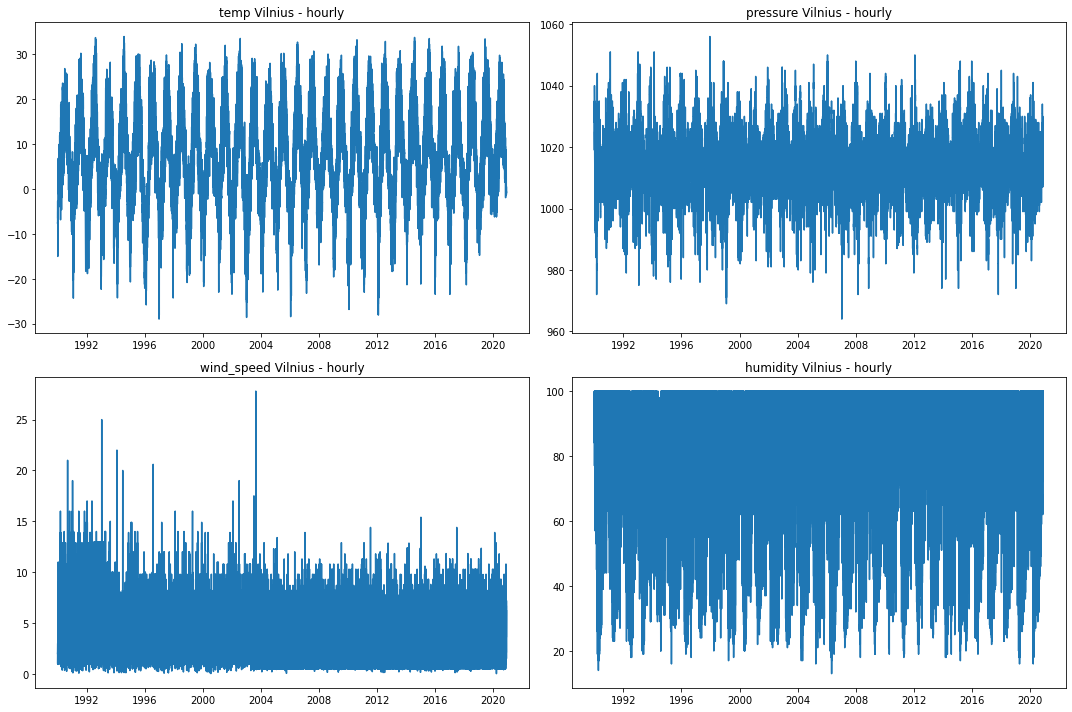

In [11]:
plot_features = d[features]
plot_features.index = d.dt

fig, axes = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(features):
    axes[i // 2, i % 2].plot(plot_features[feature])
    axes[i // 2, i % 2].set_title(f'{feature} Vilnius - hourly')
        
plt.tight_layout()

plt.show()

## Daily data 

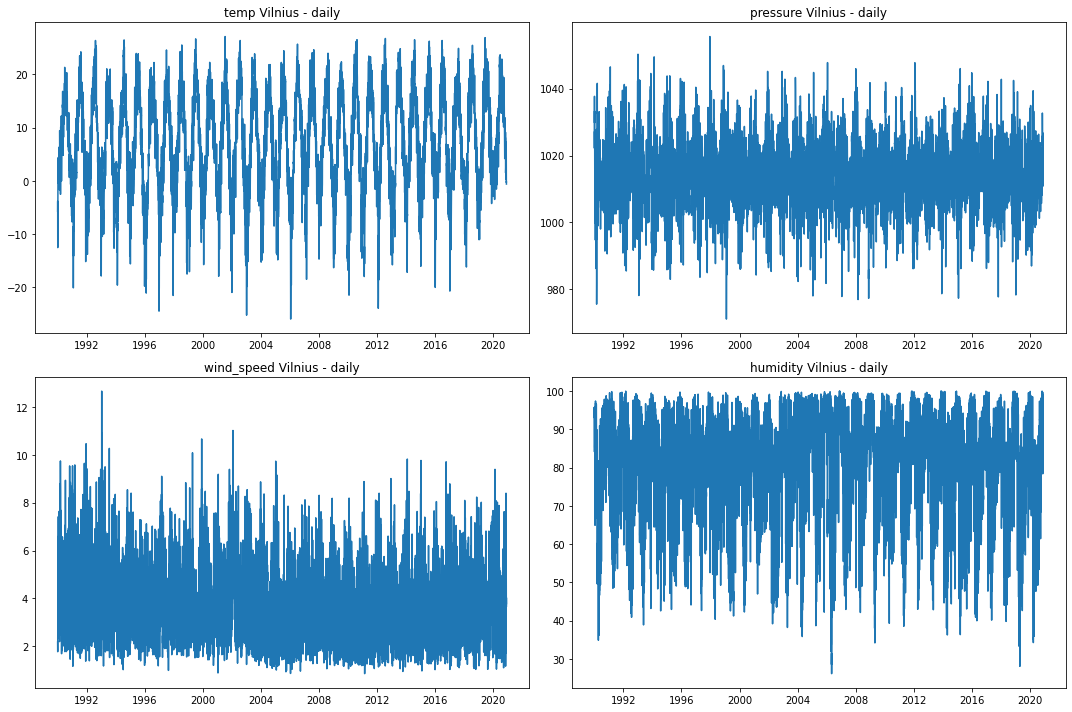

In [12]:
plot_features = d.groupby('date')[features].mean()

fig, axes = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(features):
    axes[i // 2, i % 2].plot(plot_features[feature])
    axes[i // 2, i % 2].set_title(f'{feature} Vilnius - daily')
        
plt.tight_layout()

plt.show()

## Heatmaps

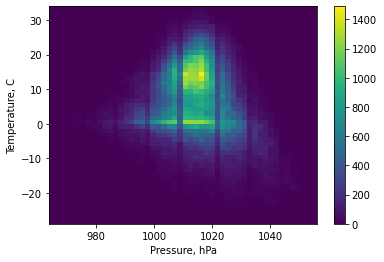

In [13]:
plt.hist2d(d['pressure'], d['temp'], bins=(50, 50))
plt.colorbar()
ax = plt.gca()
plt.xlabel('Pressure, hPa')
plt.ylabel('Temperature, C')
ax.axis('tight')
plt.show()

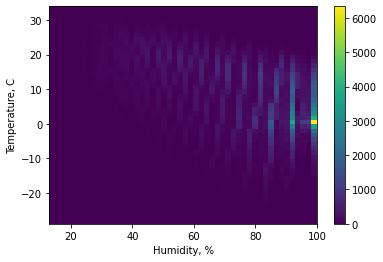

In [14]:
plt.hist2d(d['humidity'], d['temp'], bins=(50, 50))
plt.colorbar()
ax = plt.gca()
plt.xlabel('Humidity, %')
plt.ylabel('Temperature, C')
ax.axis('tight')
plt.show()

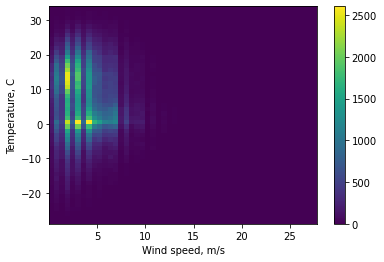

In [15]:
plt.hist2d(d['wind_speed'], d['temp'], bins=(50, 50))
plt.colorbar()
ax = plt.gca()
plt.xlabel('Wind speed, m/s')
plt.ylabel('Temperature, C')
ax.axis('tight')
plt.show()

# Feature engineering

In [16]:
# Extracting the timestamp from dt 
timestamp = [x.timestamp() for x in d['dt']]

# Creating the time of day and time of year signals
day = 24 * 60 * 60
year = (365.2425) * day

d['day_cos'] = [np.cos(x * (2 * np.pi / day)) for x in timestamp]
d['year_cos'] = [np.cos(x * (2 * np.pi / year)) for x in timestamp]

#d['day_sin'] = [np.sin(x * (2 * np.pi / day)) for x in timestamp]
#d['year_sin'] = [np.sin(x * (2 * np.pi / year)) for x in timestamp]

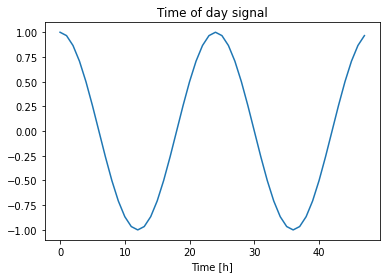

In [17]:
# Ploting the first 48 hours 
plt.plot(np.array(d['day_cos'])[:48])
#plt.plot(np.array(d['day_sin'])[:48])
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.show()

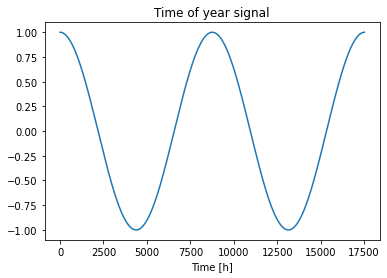

In [18]:
# Ploting the first 2 years
plt.plot(np.array(d['year_cos'])[:48 * 365])
#plt.plot(np.array(d['year_sin'])[:48 * 365])
plt.xlabel('Time [h]')
plt.title('Time of year signal')
plt.show()

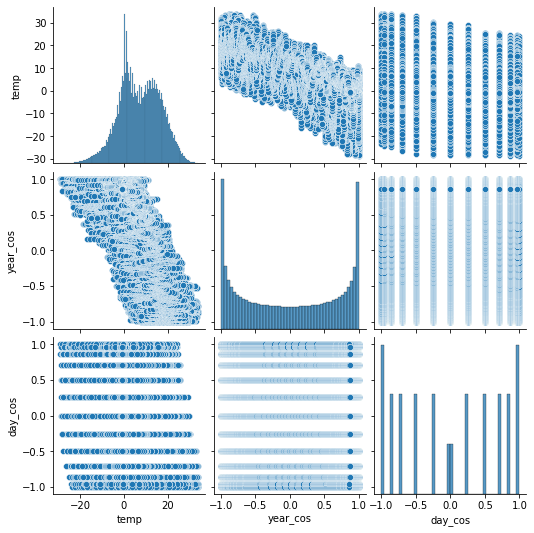

In [19]:
sns.pairplot(d[['temp', 'year_cos', 'day_cos']])
plt.show()

# Single step forecast

## Hyper parameters

In [20]:
# Number of lags (hours back) to use for models
lag = 48

# Steps ahead to forecast 
n_ahead = 1

# Share of obs in testing 
test_share = 0.1

# Hyper parameters for the model 
epochs = 10
batch_size = 512
lr = 0.001
n_layer = 10

## Creating the matrices for training

In [21]:
# Subseting only the needed columns 
ts = d[['temp', 'pressure', 'wind_speed', 'humidity', 'day_cos', 'year_cos']]

nrows = ts.shape[0]

# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]

# Scaling the data 
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Creating the final scaled frame 
ts_s = pd.concat([train, test])

In [22]:
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

print(f"Shape of training data: {X.shape}")
print(f"Shape of the target data: {Y.shape}")

n_ft = X.shape[2]

Shape of training data: (270959, 48, 6)
Shape of the target data: (270959, 1)


In [23]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

# Defining the model 

In [24]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Masking layer 
        lstm_layer = Masking(mask_value=mask_value)(lstm_input)

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_layer)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=2, min_delta=0.001)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

In [25]:
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

In [26]:
model.model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 6)]           0         
_________________________________________________________________
masking (Masking)            (None, 48, 6)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                680       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 691
Trainable params: 691
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.train()

Epoch 1/10
477/477 [==============================] - 12s 25ms/step - loss: 0.3376 - val_loss: 0.1426
Epoch 2/10
477/477 [==============================] - 10s 21ms/step - loss: 0.1189 - val_loss: 0.0885
Epoch 3/10
477/477 [==============================] - 11s 24ms/step - loss: 0.0899 - val_loss: 0.0675
Epoch 4/10
477/477 [==============================] - 11s 23ms/step - loss: 0.0781 - val_loss: 0.0669
Epoch 5/10
477/477 [==============================] - 10s 21ms/step - loss: 0.0708 - val_loss: 0.0666
Epoch 6/10
477/477 [==============================] - 10s 21ms/step - loss: 0.0702 - val_loss: 0.0588
Epoch 7/10
477/477 [==============================] - 10s 21ms/step - loss: 0.0642 - val_loss: 0.0556
Epoch 8/10
477/477 [==============================] - 10s 21ms/step - loss: 0.0643 - val_loss: 0.0666
Epoch 9/10
477/477 [==============================] - 10s 21ms/step - loss: 0.0624 - val_loss: 0.0565
Epoch 10/10
477/477 [==============================] - 10s 22ms/step - loss: 0.065

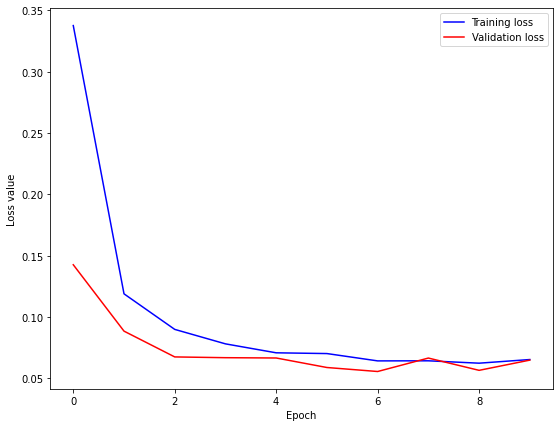

In [28]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [29]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]

In [30]:
# Creating the frame to store both predictions
days = d['dt'].values[-len(y):]

frame = pd.concat([
    pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'temp': yhat, 'type': 'forecast'})
])

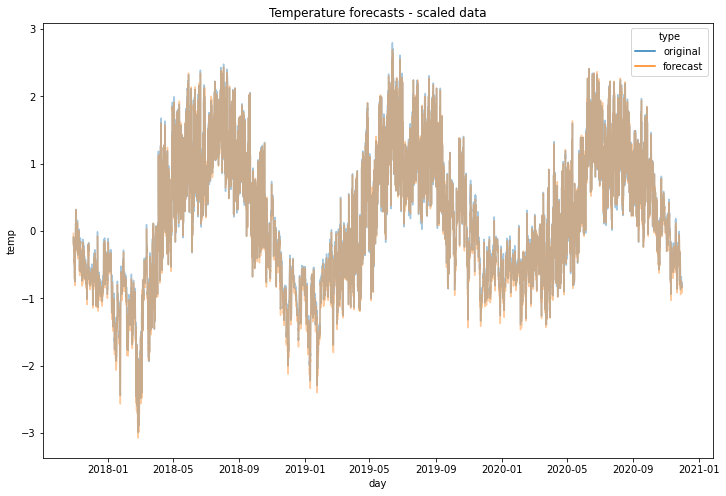

In [31]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='day', y='temp', data=frame, hue='type', alpha=0.4)
plt.title('Temperature forecasts - scaled data')
plt.show()

In [32]:
frame_abs = frame.copy()
frame_abs['temp'] = [(x * train_std['temp']) + train_mean['temp'] for x in frame_abs['temp']]

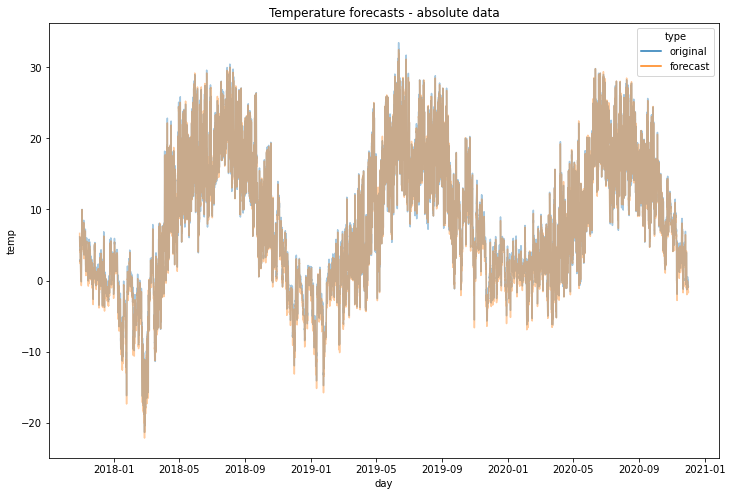

In [33]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='day', y='temp', data=frame_abs, hue='type', alpha=0.4)
plt.title('Temperature forecasts - absolute data')
plt.show()

In [34]:
pivoted = frame_abs.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_original'] - pivoted['temp_forecast']

In [35]:
print(f"Average absolute mean error: {round(np.sum([abs(x) for x in pivoted['res']]) / pivoted.shape[0], 2)} C")

Average absolute mean error: 0.61 C


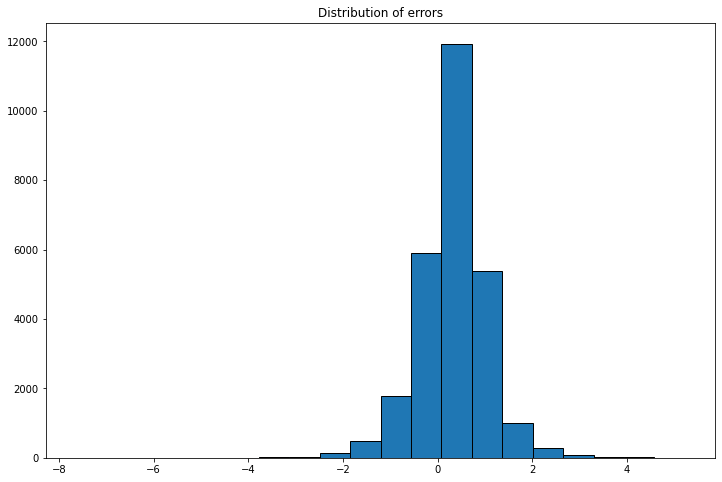

In [36]:
plt.figure(figsize=(12, 8))
plt.hist(pivoted.res, bins=20, edgecolor='black')
plt.title('Distribution of errors')
plt.show()

# Sequence prediction 

In [37]:
# Number of lags (hours back) to use for models
lag = 96

# Steps ahead to forecast 
n_ahead = 24

# Share of obs in testing 
test_share = 0.1

# Hyper parameters for the model 
epochs = 12
batch_size = 512
lr = 0.001
n_layer = 10

In [38]:
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

print(f"Shape of training data: {X.shape}")
print(f"Shape of the target data: {Y.shape}")

n_ft = X.shape[2]

Shape of training data: (270888, 96, 6)
Shape of the target data: (270888, 24)


In [39]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [40]:
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

In [41]:
model.model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 6)]           0         
_________________________________________________________________
masking_1 (Masking)          (None, 96, 6)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                680       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                264       
Total params: 944
Trainable params: 944
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.train()

Epoch 1/12
477/477 [==============================] - 22s 47ms/step - loss: 0.5231 - val_loss: 0.3045
Epoch 2/12
477/477 [==============================] - 19s 39ms/step - loss: 0.2786 - val_loss: 0.2543
Epoch 3/12
477/477 [==============================] - 19s 39ms/step - loss: 0.2377 - val_loss: 0.2080
Epoch 4/12
477/477 [==============================] - 19s 39ms/step - loss: 0.2102 - val_loss: 0.1980
Epoch 5/12
477/477 [==============================] - 18s 39ms/step - loss: 0.2008 - val_loss: 0.1912
Epoch 6/12
477/477 [==============================] - 21s 43ms/step - loss: 0.1962 - val_loss: 0.1860
Epoch 7/12
477/477 [==============================] - 22s 47ms/step - loss: 0.1933 - val_loss: 0.1865
Epoch 8/12
477/477 [==============================] - 22s 47ms/step - loss: 0.1911 - val_loss: 0.1825
Epoch 9/12
477/477 [==============================] - 19s 40ms/step - loss: 0.1897 - val_loss: 0.1841
Epoch 10/12
477/477 [==============================] - 24s 49ms/step - loss: 0.187

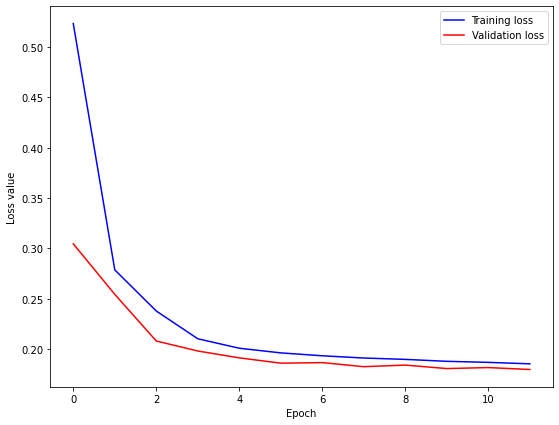

In [43]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [44]:
# Forecasting on all the samples in the validation set 
forecast = model.predict(Xval)

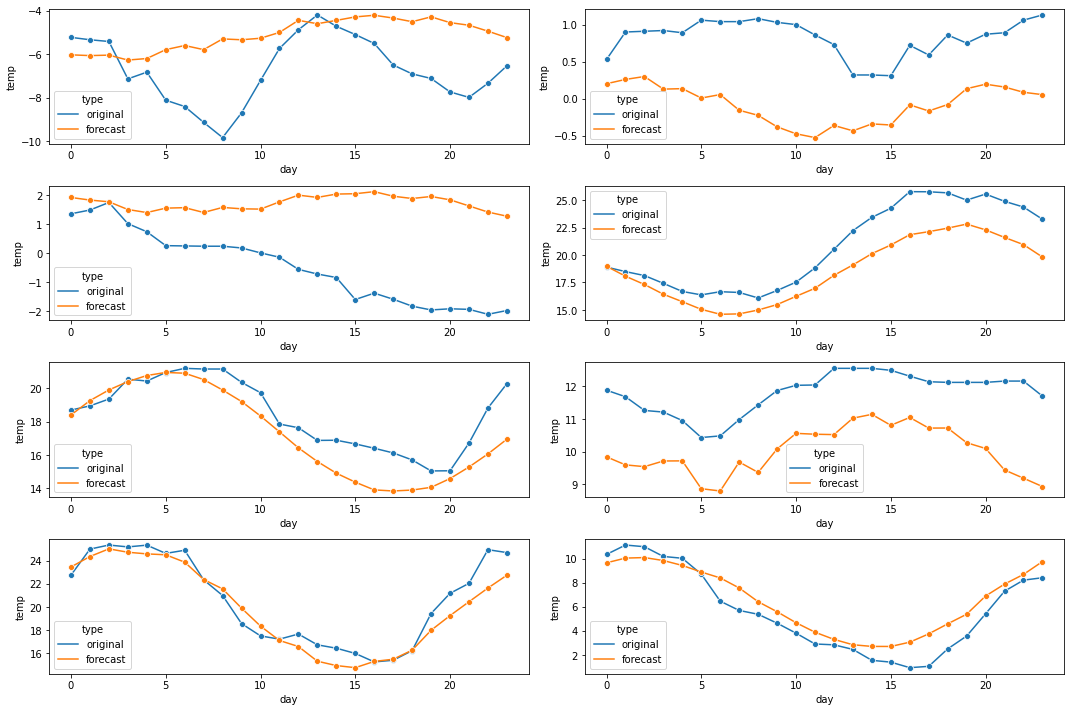

In [47]:
fig, axes = plt.subplots(
    nrows=4, 
    ncols=2, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

indexes = random.sample(range(len(forecast)), 8)

for i, index in enumerate(indexes):
    
    yhat = forecast[index]
    y = Yval[index]

    frame = pd.concat([
        pd.DataFrame({'day': range(len(y)), 'temp': y, 'type': 'original'}),
        pd.DataFrame({'day': range(len(y)), 'temp': yhat, 'type': 'forecast'})
    ])
    
    frame['temp'] = [(x * train_std['temp']) + train_mean['temp'] for x in frame['temp']]
    
    sns.lineplot(x='day', y='temp', ax = axes[i // 2, i % 2], data=frame, hue='type', marker='o')
        
plt.tight_layout()

plt.show()

In [46]:
# Calculating the total average absolute error 
error = 0 
n = 0

for i in range(Yval.shape[0]):
    true = Yval[i]
    hat = forecast[i]
    n += len(true)
    
    true = [(x * train_std['temp']) + train_mean['temp'] for x in true]
    hat = [(x * train_std['temp']) + train_mean['temp'] for x in hat]
    
    error += np.sum([abs(x) for x in true - hat]) 

print(f'Final average absolute error: {round(error / n, 2)} C')

Final average absolute error: 0.18 C
